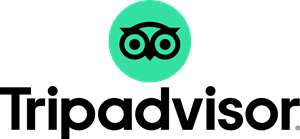


# Проект 3. «О вкусной и здоровой пище»

### [SF-DST-23] Restaurant Rating prediction Alina Cherkas



#### *Проект посвящен построению модели, которая предсказывает рейтинг ресторана на сайте TripAdvisor.*

## Import

In [1]:
import os
import ast
import numpy as np
import pandas as pd

import missingno as msgn
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

plt.style.use('seaborn-deep')  # выбор стиля графиков
sns.set_style("whitegrid")
sns.axes_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from datetime import datetime

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tripadvisor-web-info/data_tripadvisor_info.csv
/kaggle/input/innovation-cities/Innovation_Cities_Index_.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/population-of-cities-in-europe/cities.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Data

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, заполняем пропуски нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Добавим данные о численности населения европейских городов
cities = pd.read_csv('../input/population-of-cities-in-europe/cities.csv')
data = pd.merge(data, cities[['City', 'Population', 'Density (/km2)']], on='City', how='left')

# Добавим глобальный рейтинг инновационных городов мира
innovation_cities = pd.read_csv('../input/innovation-cities/Innovation_Cities_Index_.csv')
innovation_cities = innovation_cities.loc[innovation_cities.REGION == 'EUROPE']
data = pd.merge(data, innovation_cities[['City', 'ABOVE OR BELOW AVERAGE RANK',
                                         '2018-2014 AVERAGE RANK Global Rank', 'City ID']],
                                          on='City', how='left')

# Добавим данные, полученные с сайта tripadvisor (идея заимствована у #Dmytro Kataiev)
# (парсинг данных производился в отдельном блокноте)
tripadvisor = pd.read_csv('../input/tripadvisor-web-info/data_tripadvisor_info.csv')
tripadvisor.drop_duplicates(subset=tripadvisor.columns[:-1], inplace=True)
data = pd.merge(data, tripadvisor, on='ID_TA', how='left')

# Посмотрим на данные
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,...,City ID,Food,Service,Value,Phone_Number,Hours,Website,Distance,Award,Distance_isNAN
418,id_418,Paris,['French'],7685.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187147-d7727343-Reviews-La...,d7727343,0,...,1002.0,40.0,35.0,35.0,1.0,1.0,1.0,0.3,0.0,0
38436,id_1400,Edinburgh,['Chinese'],1401.0,NaN,3.0,"[['Perfect service', 'Good Food , Good Service...",/Restaurant_Review-g186525-d4925463-Reviews-Ma...,d4925463,1,...,368.0,NaN,NaN,NaN,1.0,1.0,1.0,1.4,0.0,0
1934,id_1934,Oslo,"['Italian', 'European', 'Vegetarian Friendly',...",472.0,$$ - $$$,353.0,"[['A sunny day spot', 'If you are hungry and n...",/Restaurant_Review-g190479-d3221276-Reviews-Be...,d3221276,0,...,978.0,35.0,35.0,30.0,1.0,1.0,1.0,0.4,0.0,0


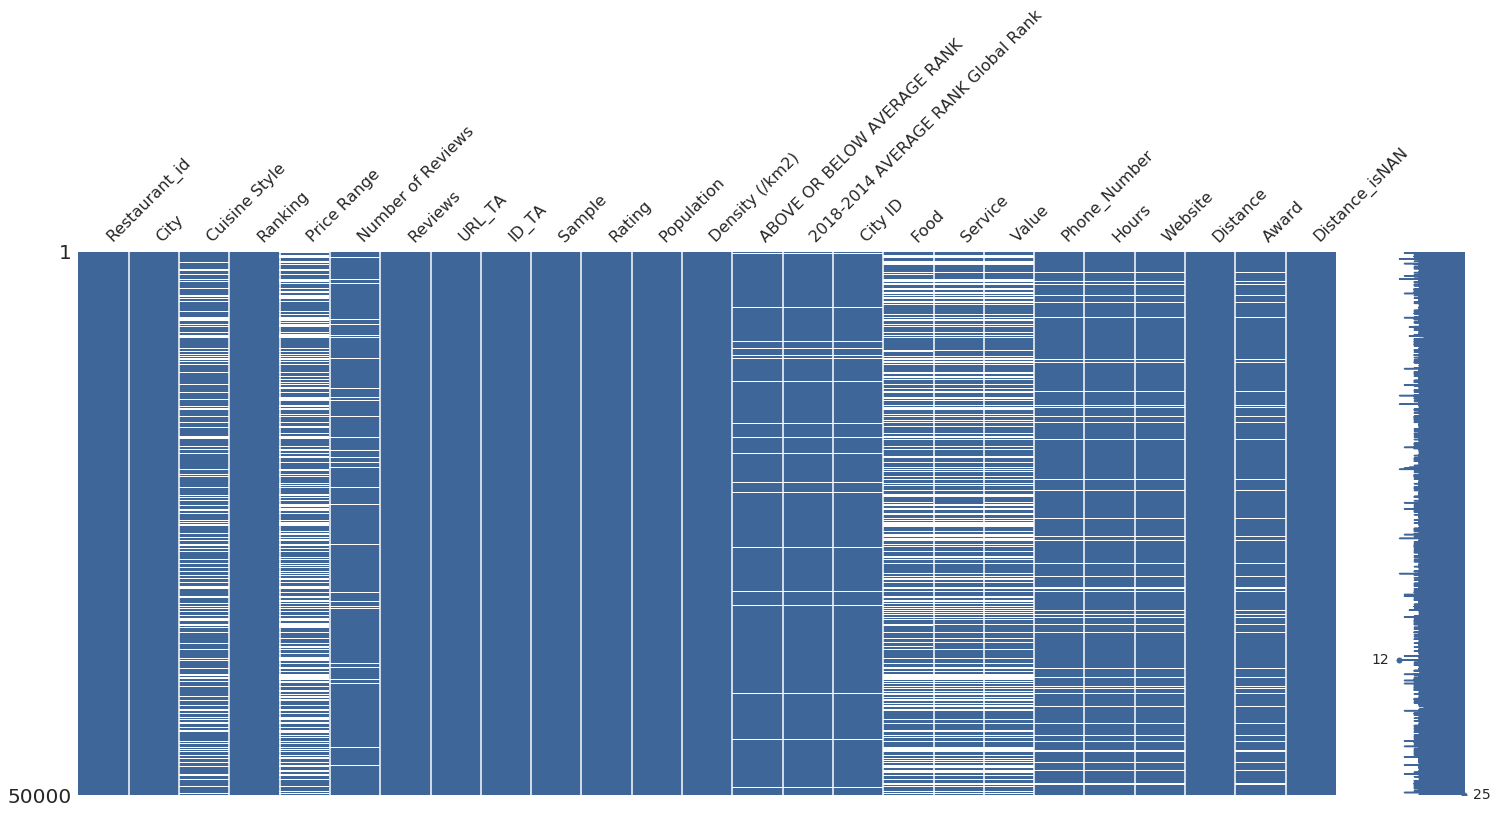

In [4]:
# Отобразим имеющиеся пропуски
msgn.matrix(data, color=(0.25, 0.4, 0.6))
plt.show()    

In [5]:
'''
# Получим процентный список пропущенных значений
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))
    
# Подсчет значений для категориальных столбцов (просмотр уникальных значений)
for col in data.columns:
    print('\nColumn Name:', col,)
    print(data[col].value_counts().sort_index())
'''

"\n# Получим процентный список пропущенных значений\nfor col in data.columns:\n    pct_missing = np.mean(data[col].isnull())\n    print('{} - {}%'.format(col, round(pct_missing * 100)))\n    \n# Подсчет значений для категориальных столбцов (просмотр уникальных значений)\nfor col in data.columns:\n    print('\nColumn Name:', col,)\n    print(data[col].value_counts().sort_index())\n"

### *Описание*

Мы имеем 40000 записей тренировочных данных и 10000 - тестовых (с отсутствующим значением целевой переменной «Rating»).

Изначально было 9 признаков, из которых числовыми являлись только 3: «Ranking», «Number of Reviews» и «Rating».
* Restaurant_id: id ресторана (числовое значение с приставкой id_)
* City: город (строка с одним словом)
* Cuisine Style: представленные кухни (строка с одним словом или несколькими)
* Ranking: ранг ресторана относительно других ресторанов в этом городе
* Price Range: цены в ресторане в 3 категориях (можно заменить на 1-3)
* Number of Reviews: количество отзывов (от 2 до 9660)
* Reviews: 2 последних отзыва и даты этих отзывов (списки в списке)
* URL_TA: страница ресторана на «tripadvisor.com» (строка)
* ID_TA: id ресторана в TripAdvisor (числовое значение с приставкой d)
* Rating: рейтинг ресторана (от 1 до 5 с шагом 0.5 - целевая переменная)

Пропуски имеются у трёх признаков: Cuisine Style (23%), Price Range (35%) и Number of Reviews (6%).

Было добавлено ещё 13 числовых признаков из трёх внешних датасетов.
- Данные по городам Европы из Википедии
    - Population: численность населения города
    - Density (/km2): плотность населения города
- Данные по рейтингу инновационных городов мира (Innovation Cities™ Index 2019 : Global)
    - 2018-2014_Average_Rank: среднее место в рейтинге инновационных городов мира с 2014 по 2018 г.
    - Above_or_Below_Average_Rank: выше или ниже среднего ранга инновационных городов мира
    - City ID: id города
    - (можно из этих данных добавить информацию о стране и об уровне качества жизни в городах, но это несущественно улучшает модель)
   
У этих признаков отсутсвует информация по двум городам: Цюриху и Кракову, что составляет 2% от всех записей. 
Поскольку мы пока не знаем уровень важности этих данных для модели, заменим пропуски медианой (лучше средним значением по стране или региону, но пока по всем данным).
- Данные, полученные с сайта «TripAdvisor» по URL 50000 записей
    - Food: оценка кухни (от 10 до 50 с шагом 5) - 32% пропусков
    - Service: оценка сервиса (от 10 до 50 с шагом 5) - 32% пропусков
    - Value: порядок цен (от 10 до 50 с шагом 5) - 32% пропусков
    - Phone_Number: номер телефона ресторана (1 - указан телефон, иначе пропуск) - 9% пропусков
    - Hours: часы работы (1 - указаны часы работы, иначе пропуск) - 9% пропусков
    - Website: наличие веб-сайта (1 - указан адрес сайта, иначе пропуск) - 9% пропусков
    - Distance: расстояние до метро (от 0 до 5 с шагом 0.1) - 0% пропусков (была предварительная обработка)
    - Award:(1 - есть награда, иначе 0 или пропуск) - 9% пропусков
    - Distance_isNAN: отсутствие информации о расстоянии до метро (1 - нет информации, иначе 0) - 9% пропусков

У признаков «Food», «Service», «Value» заменим пропуски медианой. У остальных заменим их нулями.

## EDA

Cтроим графики, ищем закономерности, аномалии, выбросы и связи между признаками. Цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.

Text(0, 0.5, 'Ranking')

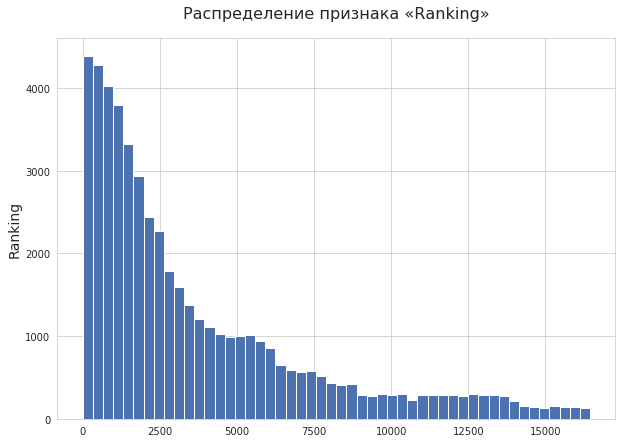

In [6]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=50)
plt.title('Распределение признака «Ranking»', fontsize=16, pad=20)
plt.ylabel('Ranking', fontsize=14)

Text(0.5, 1.0, 'Распределение признака «City»')

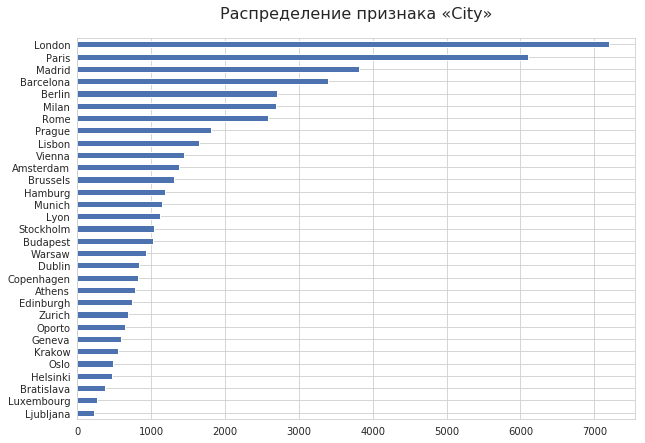

In [7]:
data['City'].value_counts(ascending=True).plot(kind='barh')
plt.title('Распределение признака «City»',
          fontsize=16, pad=20)

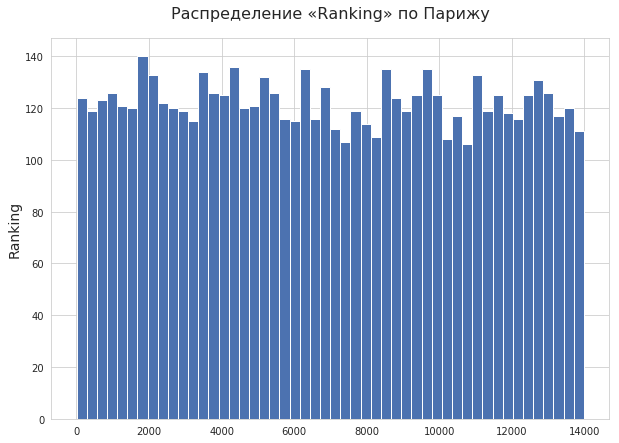

In [8]:
data['Ranking'][data['City'] =='Paris'].hist(bins=50)
plt.title('Распределение «Ranking» по Парижу',
          fontsize=16, pad=20)
plt.ylabel('Ranking', fontsize=14)
plt.show()

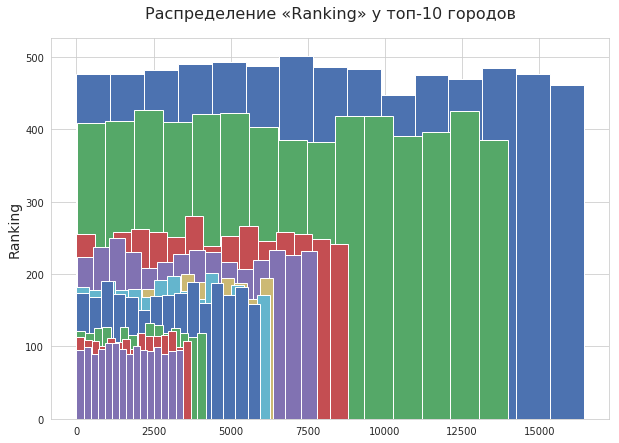

In [9]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=15)
    
plt.title('Распределение «Ranking» у топ-10 городов',
          fontsize=16, pad=20)
plt.ylabel('Ranking', fontsize=14)
plt.show()

Ranking имеет нормальное распределение, однако в больших городах больше ресторанов, из-за имеется смещение.

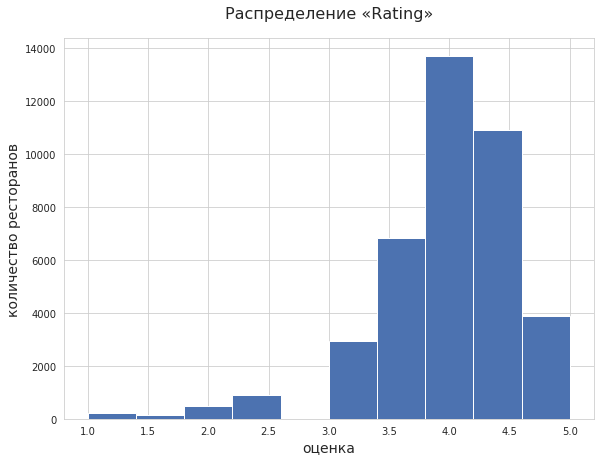

In [10]:
fig, ax = plt.subplots(figsize=(9.5, 7))
ax.hist(df_train['Rating'])
ax.set_title('Распределение «Rating»', fontsize=16, pad=20)
ax.set_xlabel('оценка', fontsize=14)
ax.set_ylabel('количество ресторанов', fontsize=14)
plt.show()

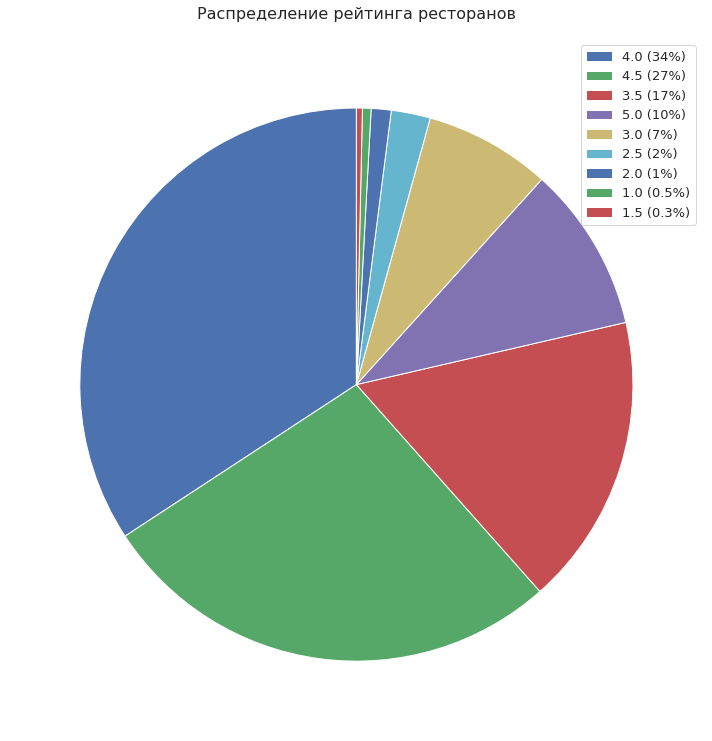

In [13]:
# 
plt.title('Распределение рейтинга ресторанов',
          fontsize=16, pad=20)
labels = [r'4.0 (34%)', r'4.5 (27%)',
          r'3.5 (17%)', r'5.0 (10%)', r'3.0 (7%)', r'2.5 (2%)',
          r'2.0 (1%)', r'1.0 (0.5%)', r'1.5 (0.3%)']
slices = df_train['Rating'].value_counts()
patches, texts = plt.pie(slices, startangle=90)
plt.legend(patches, labels, loc="best", fontsize=13)
plt.tight_layout()
plt.show()
plt.rcParams["figure.figsize"] = [10, 12]


### *Решение*

1. Преобразуем значения столбцов «Restaurant_id» и «ID_TA» в числовой тип данных подразумевая, что id присваивался по порядку и наименьшее значение «Restaurant_id» соответсвует раннему появлению ресторана, а наименьшее значение «ID_TA» соответсвует раннему появлению в базе TripAdvisor.
2. Заменим значения в столбце «Price_Range» на числовой тип данных.
3. Из столбца «Reviews» получим даты последних отзывов и создадим новый признак - количество дней между двумя последними отзывами.
4. Выделим одиночные рестораны и сети, подсчитав количество записей на один «Restaurant_id».
5. Подсчитаем количество кухонь на один ресторан.
6. Узнаем количество ресторанов по городам.
7. Нормируем признаки «Number_of_Reviews» и «Ranking» по максимальному значению в городе.
8. Объединим признаки, полученные из данных с сайта, в один признак (с их последующим удалением) для усиления влияния на модель и избежания сильной корреляции между ними.
9. Создадим dummy-признаки для стилей кухни.
10. Создадим три новых признака путем умножения друг на друга одних и делением на другие.
11. Оставим только числовые признаки.
12. Применим функцию к данным и построем матрицу корреляции.
13. Заменяем сильно коррелирующие признаки на один методом главных компонент.
14. Тестируем модель и оставляем оптимальный набор признаков с наименьшим MAE.
15. Вычислим коэффициент детерминации для проверки соответствия модели данным.

## Data Preprocessing

In [14]:
# Для удобства и воспроизводимости кода завернем всю обработку в одну большую функцию
def preproc_data(df_input):
    
    df_output = df_input.copy()

    # ########################### 1. Prepping ######################################

    # 1.1. Переименуем столбцы так, чтобы в них отсутствовали пробелы
    df_output = df_output.rename(
        columns={
            'Cuisine Style': 'Cuisine_Style',
            'Price Range': 'Price_Range',
            'Number of Reviews': 'Number_of_Reviews',
            'Area (km2)': 'Area_(km2)',
            'Density (/km2)': 'Density_(/km2)',
            '2018-2014 AVERAGE RANK Global Rank': '2018-2014_Average_Rank',
            'ABOVE OR BELOW AVERAGE RANK': 'Above_or_Below_Average_Rank'
        })

    # 1.2. # Уберём запятые из больших чисел и преобразуем столбцы в числовой тип данных
    def del_commas(x):
        x = x.str.replace(',', '')
        x = pd.to_numeric(x)
        return x

    df_output['Population'] = df_output[['Population']].apply(del_commas)
    df_output['Density_(/km2)'] = df_output[['Density_(/km2)'
                                             ]].apply(del_commas)

    # 1.3. Представим численность населения в миллионах
    df_output['Population'] = df_output['Population'] / 1000000

    # 1.4. Заменим пропуски у тех признаков, у которых уже можем это сделать
    df_output.fillna(
        {
            '2018-2014_Average_Rank': df_output['2018-2014_Average_Rank'].median(),
            'Above_or_Below_Average_Rank':
            df_output['Above_or_Below_Average_Rank'].median(),
            'Food': df_output['Food'].median(),
            'Service': df_output['Service'].median(),
            'Value': df_output['Value'].median(),
            'Phone_Number': 0,
            'Hours': 0,
            'Website': 0,
            'Award':0
        },
        inplace=True)

    # 1.5. Удалим записи с совпадением по id ресторана в базе данных TripAdvisor и по отзывам
    #df_output.drop_duplicates(subset=['ID_TA', 'Reviews'], inplace=True) - ухудшает модель

    # 1.4. Оставим только числовое значение у «Restaurant_id» и «ID_TA»
    df_output.ID_TA = df_output.ID_TA.str.replace('d', '')
    df_output.ID_TA = [int(x) for x in df_output.ID_TA]
    df_output.Restaurant_id = df_output.Restaurant_id.str.replace('id_', '')
    df_output.Restaurant_id = [int(x) for x in df_output.Restaurant_id]

    # 1.5. Заменим в столбце «Price_Range» строковые обозначения на числа
    price_range = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price_Range'] = df_output['Price_Range'].replace(
        to_replace=price_range)

    # 1.6 Вычленим даты из стобца «Reviews»
    df_output["Reviews"] = df_output["Reviews"].str.replace("nan", "' '")
    df_output["Reviews"].fillna("[[], []]", inplace=True)
    df_output["Reviews"] = df_output["Reviews"].apply(
        lambda x: ast.literal_eval(x))
    df_output["Dates_of_Reviews"] = df_output["Reviews"].apply(
        lambda x: [datetime.strptime(d, "%m/%d/%Y") for d in x[1]])
    df_output["Dates_of_Reviews"] = df_output["Dates_of_Reviews"].apply(
        lambda x: [x[i] for i in [1, 0]]
        if ((len(x) > 1) and (x[1] > x[0])) else x)

    # ####################### 2. Feature Engineering ######################################

    # 2.1. Новый признак «Number_of_Restaurants» (кол-во ресторанов на один «Restaurant_id»)
    df = pd.DataFrame(df_output, columns=['Restaurant_id'])
    df_new = df['Restaurant_id'].value_counts().to_frame().reset_index(
    ).rename(columns={
        'index': 'Restaurant_id',
        'Restaurant_id': 'Number_of_Restaurants'
    })
    df_output = pd.merge(df_output, df_new, on='Restaurant_id')

    # 2.2. Новый признак «Cuisines_Count» (количество кухонь в ресторане)
    df_output['Cuisine_Style_isNAN'] = pd.isna(
        df_output['Cuisine_Style']).astype('uint8')
    
    df_output['Cuisine_Style'] = df_output['Cuisine_Style'].apply(
        lambda x: ['Local'] if pd.isnull(x) else x[1:-1].split(','))
        
    df_output['Cuisines_Count'] = df_output['Cuisine_Style'].apply(
        lambda x: len(x))

    # 2.3. Новый признак «Days_between_Reviews» (кол-во дней между двумя последними отзывами):
    df_output["Days_between_Reviews"] = df_output["Dates_of_Reviews"].apply(
        lambda x: (x[0] - x[1]).days if len(x) > 1 else 0)

    # 2.4. Новый признак «Number_of_Restaurant_per_City»
    df = pd.DataFrame(df_output, columns=['City'])
        
    df_new = df['City'].value_counts().to_frame().reset_index().rename(
        columns={
            'index': 'City',
            'City': 'Number_of_Restaurant_per_City'
        })
    df_output = pd.merge(df_output, df_new, on='City')

    # 2.5. Новый признак «Number_of_Reviews_per_City»
    mean_reviews_per_city = (df_output.groupby(
        ['City'])['Number_of_Reviews'].mean().to_dict())
        
    df_output['Number_of_Reviews_per_City'] = df_output['City'].apply(
        lambda x: round(mean_reviews_per_city[x]))

    # 2.6. Новый признак «New_Number_of_Reviews» (нормирование «Number_of_Reviews» по городу)
    # Создадим столбец с максимальным значением «Number_of_Reviews» по городу
    max_ranking_per_city = (df_output.groupby(
        ['City'])['Number_of_Reviews'].max().to_dict())

    df_output['Max_Reviews_per_City'] = df_output['City'].apply(
        lambda x: round(max_ranking_per_city[x]))

    df_output['New_Number_of_Reviews'] = (df_output['Number_of_Reviews'] /
                                          df_output['Max_Reviews_per_City'])

    # 2.7. Создадим новый признак «New_Ranking» с нормированием «Ranking» по городу
    max_ranking_per_city = (df_output.groupby(['City'
                                               ])['Ranking'].max().to_dict())

    df_output['Max_Ranking_per_City'] = df_output['City'].apply(
        lambda x: round(max_ranking_per_city[x]))

    df_output['New_Ranking'] = df_output['Ranking'] / df_output[
        'Max_Ranking_per_City']

    # 2.8. Создадим новый признак «Web_info_Sum» на основе информации с сайта
    df_output['Web_info_Sum'] = (df_output['Food'] + df_output['Service'] +
                                 df_output['Value'] +
                                 df_output['Phone_Number'] +
                                 df_output['Hours'] + df_output['Website'] +
                                 df_output['Award'])

    # ################################ 3. NAN #############################################

    # 3.1. Создадим новые признаки на основе пропущенных значений в этих столбцах
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number_of_Reviews']).astype('uint8')
    df_output['Price_Range_isNAN'] = pd.isna(
        df_output['Price_Range']).astype('uint8')

    # 3.2. Заполним пропуски в столбце «Price_Range» медианой:
    median_price_range = df_output['Price_Range'].median()
    df_output['Price_Range'] = df_output['Price_Range'].fillna(
        median_price_range)

    # 3.3. Заполним пропуски в столбце «New_Number_of_Reviews» на среднее значение по городу
    df_output['New_Number_of_Reviews'] = df_output['Number_of_Reviews'].fillna(
        round(df_output['Number_of_Reviews_per_City']))

    # ############################## 4. Encoding ###########################################

    # 4.1. One-Hot Encoding признака «Cuisine_Style»
    # Создадим перечень кухонь
    def get_cuisines_list(df):
        cuisines = set()
        for cuisine in df['Cuisine_Style'].values:
            cuisines.update(cuisine)
        return cuisines

    list_of_cuisines = get_cuisines_list(df_output)

    # Подсчитаем насколько часто встречается каждая кухня
    def count_cuisines_prevalence(df, kit):
        cuisines_prevalence = {}
        for cuisine in kit:
            cuisines_prevalence[cuisine] = 0

        for cuisine in df['Cuisine_Style'].values:
            for style in cuisine:
                cuisines_prevalence[style] = cuisines_prevalence[style] + 1
        return cuisines_prevalence

    prevalence_cuisine = count_cuisines_prevalence(df_output, list_of_cuisines)

    # Выделим две группы кухонь:
    # часто встречающиеся (представлены более, чем в 10% ресторанов) и остальные
    top_cuisines = []
    low_cuisines = []
    for cuisine in prevalence_cuisine:
        if prevalence_cuisine[cuisine] > len(df_output) * .1:
            top_cuisines.append(cuisine)
        else:
            low_cuisines.append(cuisine)

    # Создадим отдельные признаки для часто встречающиеся кухонь
    def frequent(x):
        return 1 if cuisine in x else 0

    for cuisine in top_cuisines:
        dummy = df_output['Cuisine_Style'].apply(frequent)
        df_output['Cuisine_' + cuisine] = dummy

    # Для остальных добавим признак «Others_Cuisines»
    def others(x):
        for cuisine in low_cuisines:
            if cuisine in x:
                return 1
        return 0

    df_output['Others_Cuisines'] = df_output['Cuisine_Style'].apply(others)

    # 4.2. One-Hot Encoding признака «City» не улучшает модель в данном случае

    # ############################## 5. New Columns #######################################

    # 5.1. Новый признак «Multi_Rating»:
    df_output['Multi_Rating'] = (
        df_output['New_Ranking'] *
        df_output['New_Number_of_Reviews']) / df_output['Population']

    # 5.2. Новый признак «Multi_Fail»
    df_output['Multi_Fail'] = df_output['Price_Range'] * df_output[
        'Distance'] * df_output['Days_between_Reviews']

    # 5.3. Новый признак «Weight_of_Rating»:
    df_output['Weight_of_Rating'] = (
        df_output['Multi_Rating'] * df_output['Above_or_Below_Average_Rank'] /
        (df_output['Number_of_Restaurant_per_City'] /
         df_output['Density_(/km2)']))

    # ################################# 6. Clean ###########################################

    # 6.1. Удалим признаки с dtypes "object"
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object'
    ]
    df_output.drop(object_columns, axis=1, inplace=True)

    # 6.2. Удалим ненужные для модели признаки
    df_output.drop([
        'Restaurant_id', 'Number_of_Reviews', 'Max_Ranking_per_City', 'Max_Reviews_per_City',
        'Density_(/km2)', 'Service', 'Value', 'Phone_Number', 'Hours',
        'Website', 'Award', 'Cuisine_Local', 'Above_or_Below_Average_Rank',
        'Distance_isNAN', "Cuisine_'Italian'", 'Number_of_Restaurants', 'Food'
    ],
        axis=1, inplace=True)

    # ############################# 7. Normalization ########################################

    # 7.1. Нормализуем все столбцы, кроме «Rating» и «Sample»
    def StandardScaler_column(d_col):
        scaler = StandardScaler()
        scaler.fit(df_output[[d_col]])
        return scaler.transform(df_output[[d_col]])

    for i in list(df_output.columns):
        if i not in ['Rating', 'Sample']:
            df_output[i] = StandardScaler_column(i)
            if len(df_output[df_output[i].isna()]) < len(df_output):
                df_output[i] = df_output[i].fillna(0)

    return df_output

In [15]:
# Применяем функцию обработки к данным
df_preproc = preproc_data(data)

In [16]:
# Посмотрим на данные после обработки
df_preproc.sample(3)

,Ranking,Price_Range,ID_TA,Sample,Rating,Population,2018-2014_Average_Rank,City ID,Distance,Cuisine_Style_isNAN,...,Price_Range_isNAN,Cuisine_ 'European',Cuisine_ 'Gluten Free Options',Cuisine_ 'Vegan Options',Cuisine_ 'Mediterranean',Cuisine_ 'Vegetarian Friendly',Others_Cuisines,Multi_Rating,Multi_Fail,Weight_of_Rating
1571,2.296607,0.286525,-1.257697,0,0.0,0.574360,-0.761350,0.777694,-0.546953,-0.549313,...,-0.729321,2.016142,-0.339851,-0.35753,2.934883,1.633517,-1.578023,-0.141390,-0.257031,0.129342
8693,-0.034710,-2.087731,-1.001292,1,4.0,2.282505,0.403884,1.073382,-0.254747,-0.549313,...,-0.729321,-0.495997,-0.339851,-0.35753,-0.340729,-0.612176,0.633704,-0.146726,-0.301753,0.123649
15589,2.942273,0.286525,-0.218042,1,3.0,-1.167859,-0.901178,0.096325,0.621868,-0.549313,...,-0.729321,-0.495997,-0.339851,-0.35753,-0.340729,-0.612176,0.633704,0.740702,0.766592,0.009829


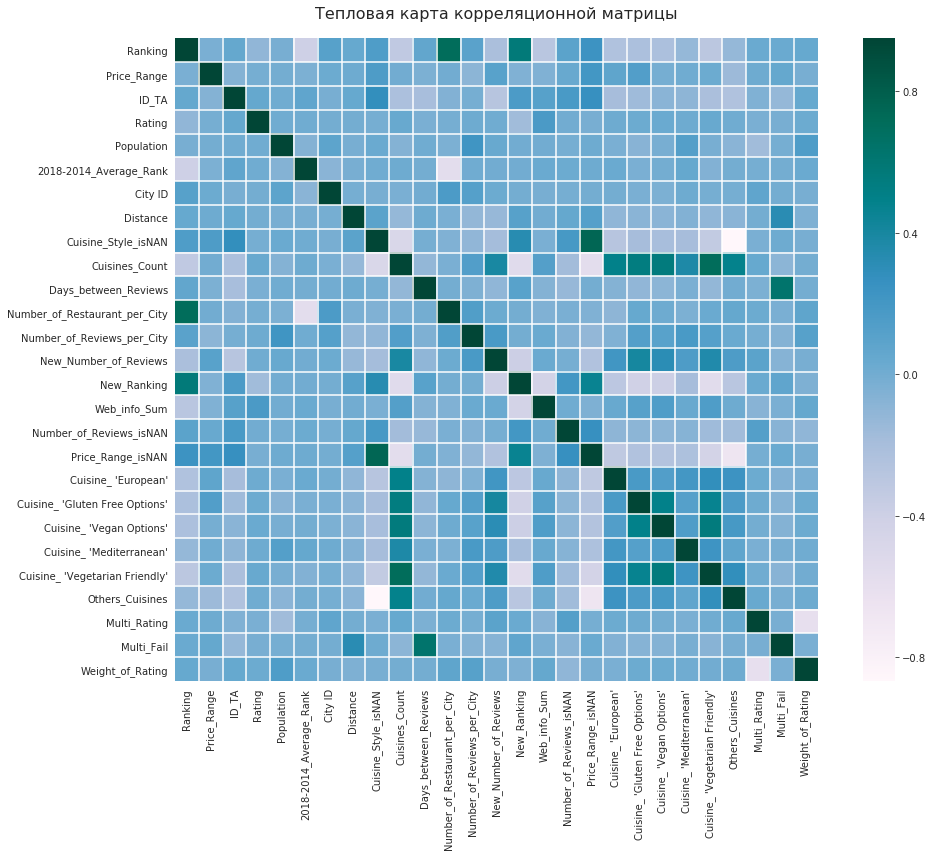

In [17]:
# Посмотрим на корреляционную матрицу
plt.rcParams['figure.figsize'] = (15, 10)
corrmat = df_preproc.drop(['Sample'], axis=1).corr()

f, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(corrmat, vmax=.95, cmap='PuBuGn', square=True)
#cmap= 'twilight_shifted'
sources = corrmat.columns.get_level_values(0)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        ax.axhline(len(sources) - i, c="w")
        ax.axvline(i, c="w")
ax.set_title('Тепловая карта корреляционной матрицы', fontsize=16, pad=20)
f.tight_layout()

## Principal Components Analysis

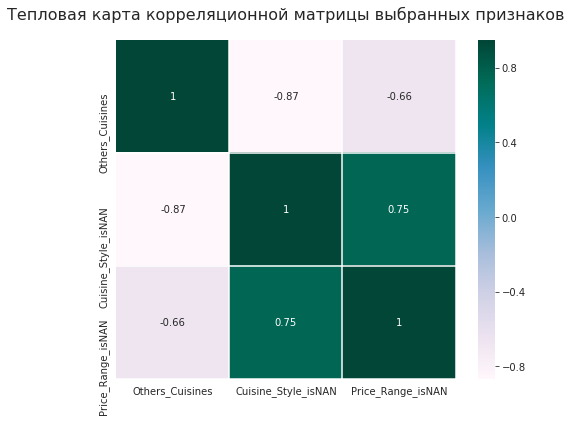

In [18]:
# Посмотрим на матрицу сильно коррелирующих признаков
C = df_preproc[['Others_Cuisines', 'Cuisine_Style_isNAN', 'Price_Range_isNAN']].corr()

f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(C, annot = True, vmax=.95, cmap='PuBuGn', square=True)
#cmap= 'twilight_shifted'
sources = corrmat.columns.get_level_values(0)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        ax.axhline(len(sources) - i, c="w")
        ax.axvline(i, c="w")
ax.set_title('Тепловая карта корреляционной матрицы выбранных признаков', fontsize=16, pad=20)
f.tight_layout()


In [19]:
# Найдем вектор главных компонент
Corr_A = np.array([
    [ 1.000000, -0.866828, -0.663372],
    [-0.866828,  1.000000,  0.753183],
    [-0.663372,  0.753183,  1.000000]])
eig_num, eig_v_A = np.linalg.eig(Corr_A)
print(f"Вектор главных компонент: {eig_v_A[:,0]}")

Вектор главных компонент: [-0.58048685  0.60110883  0.54927514]


In [20]:
# Заменим сильно коррелированные признаки на один и удалим их
df_preproc['Cuisines_Others'] = (eig_v_A[:,0][0]*df_preproc['Others_Cuisines'] +
                                 eig_v_A[:,0][1]*df_preproc['Cuisine_Style_isNAN'] +
                                 eig_v_A[:,0][2]*df_preproc['Price_Range_isNAN'])

df_preproc.drop(['Others_Cuisines', 'Cuisine_Style_isNAN', 'Price_Range_isNAN'],
                 axis = 1, inplace=True)

In [21]:
# Проверка
df_preproc.shape

(50000, 26)

## Train the model

In [22]:
# Выделим тестовую часть
train_data = df_preproc.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df_preproc.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values  # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

# Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 25), (40000, 25), (40000, 24), (32000, 24), (8000, 24))

In [23]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100,
                              verbose=1,
                              n_jobs=-1,
                              random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = np.array(
    [5.0 if x > 5 else x for x in list(np.round(y_pred * 2) / 2)])

# Метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических
MAE = metrics.mean_absolute_error(y_test, y_pred)
try:
    title = 'MAE: ' + str(round(MAE, 4)) + ', до изменений: ' + str(round(old_MAE, 4))
except:
    title = 'MAE: ' + str(MAE)
old_MAE = MAE

# Выводим самые важные признаки для модели
layout = go.Layout(autosize=False, width=1000, height=500)
fig = go.Figure(layout=layout)
fig.add_trace(
    go.Bar(x=model.feature_importances_, y=X.columns, orientation='h')),
fig.update_layout(title=title,
                  title_x=0.5,
                  yaxis={'categoryorder': 'total descending'},
                  margin=dict(l=200, r=100, t=50, b=0),
                  showlegend=False)
fig.update_traces(marker_color='rgb(36,93,172)',
                  marker_line_color='rgb(225,235,255)',
                  marker_line_width=1.5, opacity=0.7)
fig.update_yaxes(range=(-.5, 20.5))
fig.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [24]:
# Блок тестирования оптимального набора признаков
'''
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
list_importance_sign = list(
    feat_importances.nlargest(len(train_data.columns)-1).index)

min_MAE = round(MAE, 4)
print(f"min_MAE = {min_MAE}", '\n')

remove = []
save = []
delta = 0.001
for i in range(0, len(list_importance_sign), 1):
    col = list_importance_sign[i]
    print(f"{i}.{col}", '\n')

    train_data = df_preproc.query('Sample == 1').drop(['Sample'], axis=1)
    test_data = df_preproc.query('Sample == 0').drop(['Sample'], axis=1)

    y = train_data.Rating.values                  # наш таргет
    X = train_data.drop(['Rating']+[col], axis=1)

    # Выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED)
    print(test_data.shape, train_data.shape,
          X.shape, X_train.shape, X_test.shape)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = np.array(
        [5.0 if x > 5 else x for x in list(np.round(y_pred * 2) / 2)])
    temp_MAE = metrics.mean_absolute_error(y_test, y_pred)

    print(temp_MAE, '\n')
    
    save.append([col, temp_MAE])
    
    if round(temp_MAE, 3) <= min_MAE-delta:
        remove.append(col)
        print(f"Удаляем: {col}", '\n')
    else:
        print(f"Оставляем: {col}", '\n')
        
print(f"Количество проверенных признаков: {i}", '\n')
print(f"List_of_Remove: {remove}", '\n')
print(f"List_of_Save: {save}")
'''

'\nfeat_importances = pd.Series(model.feature_importances_, index=X.columns)\nlist_importance_sign = list(\n    feat_importances.nlargest(len(train_data.columns)-1).index)\n\nmin_MAE = round(MAE, 4)\nprint(f"min_MAE = {min_MAE}", \'\n\')\n\nremove = []\nsave = []\ndelta = 0.001\nfor i in range(0, len(list_importance_sign), 1):\n    col = list_importance_sign[i]\n    print(f"{i}.{col}", \'\n\')\n\n    train_data = df_preproc.query(\'Sample == 1\').drop([\'Sample\'], axis=1)\n    test_data = df_preproc.query(\'Sample == 0\').drop([\'Sample\'], axis=1)\n\n    y = train_data.Rating.values                  # наш таргет\n    X = train_data.drop([\'Rating\']+[col], axis=1)\n\n    # Выделим 20% данных на валидацию (параметр test_size)\n    X_train, X_test, y_train, y_test = train_test_split(\n        X, y, test_size=0.2, random_state=RANDOM_SEED)\n    print(test_data.shape, train_data.shape,\n          X.shape, X_train.shape, X_test.shape)\n\n    model.fit(X_train, y_train)\n\n    y_pred = mod

List_of_Remove: ['Number_of_Restaurants', 0.14575] 

List_of_Save: [['Web_info_Sum', 0.1686875], ['Ranking', 0.147375], ['Number_of_Restaurant_per_City', 0.1470625], ['Multi_Rating', 0.1505625], ['Weight_of_Rating', 0.1485], ['ID_TA', 0.1513125], ['New_Number_of_Reviews', 0.1525625], ['Number_of_Reviews_isNAN', 0.1480625], ['2018-2014_Average_Rank', 0.1471875], ['City ID', 0.146375], ['Number_of_Reviews_per_City', 0.1480625], ['Days_between_Reviews', 0.1464375], ['Distance', 0.146625], ['Population', 0.1480625], ['Multi_Fail', 0.146875], ['Cuisines_Count', 0.149], ['Cuisines_Others', 0.1475], ['Price_Range', 0.147875], ["Cuisine_ 'Mediterranean'", 0.1491875], ["Cuisine_ 'European'", 0.1478125], ["Cuisine_ 'Vegetarian Friendly'", 0.1481875], ["Cuisine_ 'Vegan Options'", 0.14675], ["Cuisine_ 'Gluten Free Options'", 0.14775]]

### *Coefficient of determination*

In [25]:
# Вычисляем коэффициент детерминации:
R2 = metrics.r2_score(y_test, y_pred)
print(round(R2, 2))

0.8


## Submission

In [26]:
# Готовим Submission на Kaggle
test_data = test_data.drop(['Rating'], axis=1)
predict_submission = model.predict(test_data)
predict_submission = np.array(
    [5.0 if x>5 else x for x in list(np.round(predict_submission * 2) / 2)])

sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,3.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.0
6,id_6,4.0
7,id_7,3.0
8,id_8,3.0
9,id_9,4.0
